In [1]:
from alphatools.research import run_pipeline, make_factor_plot
from alphatools.expression import ExpressionAlpha
from alphatools.ics import Sector
from alphatools.ics import SubIndustry as Industry
from zipline.pipeline.factors import AverageDollarVolume, Returns
from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing as USEP

In [2]:
universe = AverageDollarVolume(window_length=120).top(2000)

In [3]:
expressions = {
    8:  '-1*rank(((sum(opens, 5)*sum(returns, 5))-delay((sum(opens, 5)*sum(returns, 5)),10)))',
    9: '((0 < ts_min(delta(close, 1), 5)) ? delta(close, 1) : ((ts_max(delta(close, 1), 5) < 0) ? delta(close, 1) : (-1 * delta(close, 1))))',
    10: 'rank(((0 < ts_min(delta(close, 1), 4)) ? delta(close, 1) : ((ts_max(delta(close, 1), 4) < 0) ? delta(close, 1) : (-1 * delta(close, 1)))))',
    53: '(-1*delta((((close-low) - (high-close)) / (close-low)), 9))',
    101: '((close - opens) / ((high - low) + .001))',
    102: 'scale((close > delay(close, 1)) ? opens : delay(opens, 1))',
    103: '-rank(stddev(returns, 60))*log(close/delay(close,5))',
    104: 'product(1+returns, 20)',
    105: 'rank(indneutralize(close))',
    'test': 'close',
    'test1': '(delta(close, 5)/delay(close,5))',
    'test2': 'rank((-(delta(close, 5)/(delay(close,5)))))',
    'test3': 'rank(indneutralize(-(delta(close, 5)/close)))',
    
}


In [4]:
#e = ExpressionAlpha(expressions[105])
#f = ExpressionAlpha(expressions['test2'])
e = ExpressionAlpha(expressions[9])

In [5]:
e.parse()
print(e.tree.pretty())

ternary
  lessthan
    number	0
    ts_min
      delta
        close
        1
      5
  delta
    close
    1
  ternary
    lessthan
      ts_max
        delta
          close
          1
        5
      number	0
    delta
      close
      1
    neg
      mult
        number	1
        delta
          close
          1



In [6]:
!pwd

/Users/jonathan/devwork/alphatools/notebooks


In [7]:
from lark.tree import pydot__tree_to_png
pydot__tree_to_png(e.tree, "alpha9.png")

In [8]:
e.transform()

<alphatools.expression.expression.ExpressionAlpha instance at 0x1c10bea908>

In [9]:
e.generate_pipeline_code()
print(e.pipeline_code)

class ExprAlpha_1(CustomFactor):
    inputs = [Returns(window_length=2), USEP.open, USEP.high,
              USEP.low, USEP.close, USEP.volume, Sector(), SubIndustry()]
    window_length = 17

    def compute(self, today, assets, out, returns, opens, high, low, close, volume, sector, subindustry):
        v0 = close - np.roll(close, 1, axis=0)
        v1 = bn.move_min(v0, window=5, min_count=1,  axis=0)
        v2 = np.less(0, v1)
        v3 = close - np.roll(close, 1, axis=0)
        v4 = close - np.roll(close, 1, axis=0)
        v5 = bn.move_max(v4, window=5, min_count=1,  axis=0)
        v6 = np.less(v5, 0)
        v7 = close - np.roll(close, 1, axis=0)
        v8 = close - np.roll(close, 1, axis=0)
        v9 = -1*v8
        v10 = np.where(v6, v7, v9)
        v11 = np.where(v2, v3, v10)
        out[:] = v11[-1]



In [123]:
expr_factor = (
    ExpressionAlpha('rank(log(close/delay(close, 5)))').
    make_pipeline_factor().
    pipeline_factor(mask=universe)
)

In [132]:
%%debug

# TODO: do this in pdb, not ipdb
p = Pipeline(screen=universe)

mr_fac = -Returns(window_length=5, mask=universe).demean(groupby=Industry()).rank()
mr_fac = -Returns(window_length=5, mask=universe).rank()
mr_fac = -Returns(window_length=5)

p.add(mr_fac, 'Control')
p.add(USEP.close.latest, 'Control_close')
p.add(e.make_pipeline_factor().pipeline_factor(mask=universe), "Expression Alpha")
#p.add(f.make_pipeline_factor().pipeline_factor(mask=universe), "Expression Alpha1")
#p.add(g.make_pipeline_factor().pipeline_factor(mask=universe), "Expression Alpha2")

start_date = '2014-01-02'
end_date = '2014-01-02'

df = run_pipeline(p, start_date, end_date)

NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
> <string>(4)<module>()

ipdb> c


In [127]:
df.head()

Control  Control_close  \
2014-01-02 00:00:00+00:00 Equity(0 [A])    -0.001602          57.19   
                          Equity(2 [AAL])   0.038095          25.25   
                          Equity(3 [AAMC]) -0.031042         930.00   
                          Equity(4 [AAN])   0.002714          29.40   
                          Equity(7 [AAP])  -0.003627         110.68   

                                            Expression Alpha  
2014-01-02 00:00:00+00:00 Equity(0 [A])                57.19  
                          Equity(2 [AAL])              25.25  
                          Equity(3 [AAMC])            930.00  
                          Equity(4 [AAN])              29.40  
                          Equity(7 [AAP])             110.68

Formatting factor data for: Control
Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: Expression Alpha
Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Time to get arrange factor data: 27.82 secs
Time to generate long/short returns: 1.69 secs


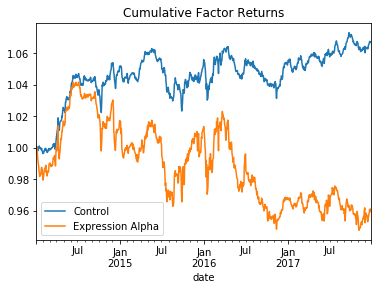

In [85]:
make_factor_plot(df, start_date, end_date);

In [27]:
e = ExpressionAlpha('rank(log(close/delay(opens, 5)))').parse().transform().generate_pipeline_code()

In [28]:
print(e.pipeline_code)

class ExprAlpha_1(CustomFactor):
    inputs = [Returns(window_length=2), USEP.open, USEP.high,
              USEP.low, USEP.close, USEP.volume]
    window_length = 7

    def compute(self, today, assets, out, returns, opens, high, low, close, volume):
        v22 = np.roll(opens, 5, axis=0)
        v23 = close / v22
        v24 = np.log(v23)
        v25 = np.apply_along_axis(rankdata, 1, v24)
        out[:] = v25[-1]



In [29]:
#M,T,W,Th,F
# delay(5) --> prior friday
# returns(window=6)

NameError: name 'a' is not defined

In [18]:
b

array([[ 0.54254437,  0.14217005],
       [ 0.37334076,  0.67413362],
       [ 0.44183317,  0.43401399],
       [ 0.61776698,  0.51313824],
       [ 0.65039718,  0.60103895],
       [ 0.8052232 ,  0.52164715],
       [ 0.90864888,  0.31923609],
       [ 0.09045935,  0.30070006],
       [ 0.11398436,  0.82868133],
       [ 0.04689632,  0.62628715]])

In [86]:
def column_corr((a, b), window=-1):
    if window==-1:
        window = a.shape[0]
    out = np.zeros(shape = (1, a.shape[1]))
    for i in xrange(a.shape[1]-1):
        out[i] = pearsonr(a[-window:, i], b[-window:, i])[0]
    return out
        

In [34]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
np.random.seed(10)
a = np.random.random(30).reshape(10,3)
b = np.random.random(30).reshape(10,3)

In [35]:
a_1 = pd.DataFrame(a)
b_1 = pd.DataFrame(b)



In [15]:
def roll_corr((a, b), window):
    out = np.ones_like(a)*np.nan
    for i in xrange(window-1, a.shape[0]):   # 2- 10
        #print "%d --> %d" % ((i-(window-1)), i)
        for j in xrange(a.shape[1]):
            out[i, j] = pearsonr(
                a[(i-(window-1)):(i), j], b[(i-(window-1)):(i), j]
            )[0]
    return out

In [36]:
a

array([[ 0.77132064,  0.02075195,  0.63364823],
       [ 0.74880388,  0.49850701,  0.22479665],
       [ 0.19806286,  0.76053071,  0.16911084],
       [ 0.08833981,  0.68535982,  0.95339335],
       [ 0.00394827,  0.51219226,  0.81262096],
       [ 0.61252607,  0.72175532,  0.29187607],
       [ 0.91777412,  0.71457578,  0.54254437],
       [ 0.14217005,  0.37334076,  0.67413362],
       [ 0.44183317,  0.43401399,  0.61776698],
       [ 0.51313824,  0.65039718,  0.60103895]])

In [37]:
np.roll(a, 2, axis=0)

array([[ 0.44183317,  0.43401399,  0.61776698],
       [ 0.51313824,  0.65039718,  0.60103895],
       [ 0.77132064,  0.02075195,  0.63364823],
       [ 0.74880388,  0.49850701,  0.22479665],
       [ 0.19806286,  0.76053071,  0.16911084],
       [ 0.08833981,  0.68535982,  0.95339335],
       [ 0.00394827,  0.51219226,  0.81262096],
       [ 0.61252607,  0.72175532,  0.29187607],
       [ 0.91777412,  0.71457578,  0.54254437],
       [ 0.14217005,  0.37334076,  0.67413362]])

In [16]:
%%timeit
out = roll_corr((a,b), window=5)

1000 loops, best of 3: 645 µs per loop


In [23]:
%%timeit
out = pd.rolling_corr(arg1=a_1, arg2=b_1, window=5)

/anaconda3/envs/py27_clean/lib/python2.7/site-packages/ipykernel_launcher.py:257: FutureWarning: pd.rolling_corr is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=5).corr(other=<DataFrame>)


100 loops, best of 3: 10.1 ms per loop


In [12]:
out[-1]

NameError: name 'out' is not defined

In [5]:
#from __future__ import division
v0 = (np.arange(5)+1.)/np.sum(np.arange(5)+1.)

out = a_1.rolling(5).apply(lambda x: (x*v0).sum()).values

In [6]:
v0

array([ 0.06666667,  0.13333333,  0.2       ,  0.26666667,  0.33333333])

In [27]:
out[-1, :]

array([ 0.48050722,  0.55059807,  0.59170856])

In [18]:
from numba import jit

In [19]:
@jit
def roll_corr2((a, b), window):
    out = np.ones_like(a)*np.nan
    for i in xrange(window-1, a.shape[0]):   # 2- 10
        #print "%d --> %d" % ((i-(window-1)), i)
        for j in xrange(a.shape[1]):
            out[i, j] = pearsonr(
                a[(i-(window-1)):(i), j], b[(i-(window-1)):(i), j]
            )[0]
    return out

ValueError: '.0' is not a valid parameter name

In [207]:
def scale(x):
    return (x - np.nanmean(x))/np.nansum(np.abs(x - np.nanmean(x)))

In [211]:
np.apply_along_axis(lambda x: (x - np.nanmean(x))/np.nansum(np.abs(x - np.nanmean(x))), 1, a)

array([[ 0.32572934, -0.5       ,  0.17427066],
       [ 0.4853247 ,  0.0146753 , -0.5       ],
       [-0.23118186,  0.5       , -0.26881814],
       [-0.5       ,  0.11250682,  0.38749318],
       [-0.5       ,  0.07890222,  0.42109778],
       [ 0.14084777,  0.35915223, -0.5       ],
       [ 0.5       , -0.02694105, -0.47305895],
       [-0.45819778, -0.04180222,  0.5       ],
       [-0.23369585, -0.26630415,  0.5       ],
       [-0.5       ,  0.41441077,  0.08558923]])

array([[ 0.77132064,  0.02075195,  0.63364823],
       [ 0.74880388,  0.49850701,  0.22479665],
       [ 0.19806286,  0.76053071,  0.16911084],
       [ 0.08833981,  0.68535982,  0.95339335],
       [ 0.00394827,  0.51219226,  0.81262096],
       [ 0.61252607,  0.72175532,  0.29187607],
       [ 0.91777412,  0.71457578,  0.54254437],
       [ 0.14217005,  0.37334076,  0.67413362],
       [ 0.44183317,  0.43401399,  0.61776698],
       [ 0.51313824,  0.65039718,  0.60103895]])

In [33]:
from __future__ import division

np.sum()

1.0

55

In [33]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
np.random.seed(2)
a = np.random.random(30).reshape(10,3)    # days x stocks
b = np.random.randint(2, 5, size=(1,3))   # Industry cat vars as integers

In [34]:
a

array([[ 0.4359949 ,  0.02592623,  0.54966248],
       [ 0.43532239,  0.4203678 ,  0.33033482],
       [ 0.20464863,  0.61927097,  0.29965467],
       [ 0.26682728,  0.62113383,  0.52914209],
       [ 0.13457995,  0.51357812,  0.18443987],
       [ 0.78533515,  0.85397529,  0.49423684],
       [ 0.84656149,  0.07964548,  0.50524609],
       [ 0.0652865 ,  0.42812233,  0.09653092],
       [ 0.12715997,  0.59674531,  0.226012  ],
       [ 0.10694568,  0.22030621,  0.34982629]])

In [35]:
b.max()+2

6

In [36]:
ohe = np.zeros((b.size, b.max()+2))
ohe[np.arange(b.size),b+1] = 1

In [37]:
ohe.T

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  0.],
       [ 1.,  0.,  1.]])

In [38]:
ind_mean = np.nan_to_num(a.dot(ohe)/ohe.sum(axis=0))

In [39]:
ind_mean

array([[ 0.        ,  0.        ,  0.        ,  0.02592623,  0.        ,
         0.49282869],
       [ 0.        ,  0.        ,  0.        ,  0.4203678 ,  0.        ,
         0.38282861],
       [ 0.        ,  0.        ,  0.        ,  0.61927097,  0.        ,
         0.25215165],
       [ 0.        ,  0.        ,  0.        ,  0.62113383,  0.        ,
         0.39798468],
       [ 0.        ,  0.        ,  0.        ,  0.51357812,  0.        ,
         0.15950991],
       [ 0.        ,  0.        ,  0.        ,  0.85397529,  0.        ,
         0.63978599],
       [ 0.        ,  0.        ,  0.        ,  0.07964548,  0.        ,
         0.67590379],
       [ 0.        ,  0.        ,  0.        ,  0.42812233,  0.        ,
         0.08090871],
       [ 0.        ,  0.        ,  0.        ,  0.59674531,  0.        ,
         0.17658599],
       [ 0.        ,  0.        ,  0.        ,  0.22030621,  0.        ,
         0.22838598]])

In [40]:
per_stock_ind_mean = ind_mean.dot(ohe.T)

In [41]:
per_stock_ind_mean # per stock ind_mean by day!

array([[ 0.49282869,  0.02592623,  0.49282869],
       [ 0.38282861,  0.4203678 ,  0.38282861],
       [ 0.25215165,  0.61927097,  0.25215165],
       [ 0.39798468,  0.62113383,  0.39798468],
       [ 0.15950991,  0.51357812,  0.15950991],
       [ 0.63978599,  0.85397529,  0.63978599],
       [ 0.67590379,  0.07964548,  0.67590379],
       [ 0.08090871,  0.42812233,  0.08090871],
       [ 0.17658599,  0.59674531,  0.17658599],
       [ 0.22838598,  0.22030621,  0.22838598]])

In [42]:
a

array([[ 0.4359949 ,  0.02592623,  0.54966248],
       [ 0.43532239,  0.4203678 ,  0.33033482],
       [ 0.20464863,  0.61927097,  0.29965467],
       [ 0.26682728,  0.62113383,  0.52914209],
       [ 0.13457995,  0.51357812,  0.18443987],
       [ 0.78533515,  0.85397529,  0.49423684],
       [ 0.84656149,  0.07964548,  0.50524609],
       [ 0.0652865 ,  0.42812233,  0.09653092],
       [ 0.12715997,  0.59674531,  0.226012  ],
       [ 0.10694568,  0.22030621,  0.34982629]])

In [43]:
a - per_stock_ind_mean

array([[-0.05683379,  0.        ,  0.05683379],
       [ 0.05249379,  0.        , -0.05249379],
       [-0.04750302,  0.        ,  0.04750302],
       [-0.13115741,  0.        ,  0.13115741],
       [-0.02492996,  0.        ,  0.02492996],
       [ 0.14554916,  0.        , -0.14554916],
       [ 0.1706577 ,  0.        , -0.1706577 ],
       [-0.01562221,  0.        ,  0.01562221],
       [-0.04942601,  0.        ,  0.04942601],
       [-0.1214403 ,  0.        ,  0.1214403 ]])